In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import pandas as pd
from seminartools.data import read_merged
from seminartools.models.pca_var_model import PCAVARModel

# 1. Read data

In [22]:
df = read_merged().reset_index()
df.head()

/Users/philipphocker/Documents/GitHub/seminar/seminartools/data.py:161: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").apply(lambda x: (1 + x).prod() - 1)  # quarterly return
/Users/philipphocker/Documents/GitHub/seminar/seminartools/data.py:397: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").mean()  # Mean interest rate


,country,date,inflation,gdp_growth,interest_rate,unemployment_rate,commodity_CRUDE_PETRO,commodity_iNATGAS,commodity_iAGRICULTURE,commodity_iMETMIN,commodity_iPRECIOUSMET
0,Japan,1977-01-01,0.022951,2.187257,6.333333,2.3,0.000,0.052425,0.144757,0.041940,0.112740
1,Canada,1977-01-01,0.023904,1.533830,8.166667,8.8,0.000,0.052425,0.144757,0.041940,0.112740
2,United States,1977-01-01,0.017231,1.186233,4.700000,8.2,0.000,0.052425,0.144757,0.041940,0.112740
3,Japan,1977-04-01,0.027244,0.703788,5.000000,2.0,-0.004,0.043586,-0.066688,-0.045412,-0.060029
4,Canada,1977-04-01,0.023346,0.510302,7.666667,8.0,-0.004,0.043586,-0.066688,-0.045412,-0.060029


# 2. VAR-X model per country

In [23]:
df.columns

Index(['country', 'date', 'inflation', 'gdp_growth', 'interest_rate',
       'unemployment_rate', 'commodity_CRUDE_PETRO', 'commodity_iNATGAS',
       'commodity_iAGRICULTURE', 'commodity_iMETMIN',
       'commodity_iPRECIOUSMET'],
      dtype='object')

In [24]:
model = PCAVARModel(
    country_column="country",
    date_column="date",
    inflation_column="inflation",
    num_pcs=2,
    country_exogenous_columns=['gdp_growth', 'interest_rate','unemployment_rate'],
    global_exogenous_columns=['commodity_CRUDE_PETRO', 'commodity_iNATGAS','commodity_iAGRICULTURE', 'commodity_iMETMIN','commodity_iPRECIOUSMET'],
    lags=[1, 2, 3, 4],
    country_exog_lags=[1],
    global_exog_lags=[1],
    standardize_pre_post=True
)

In [25]:
#model.fit(df.query("yearmonth <= '2010-01-01'"))
model.fit(df)

Text(0.5, 1.0, 'Fraction of variance explained by each principal component')

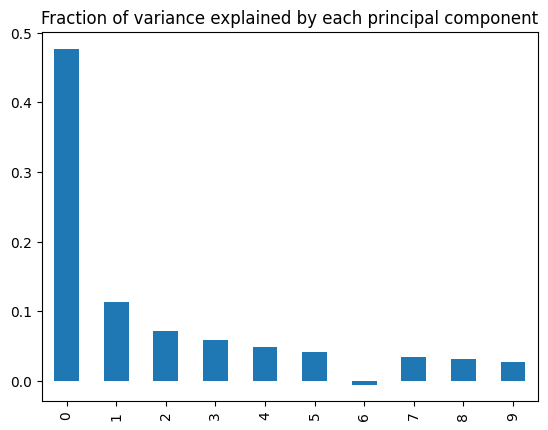

In [26]:
import matplotlib.pyplot as plt

pd.Series(model.all_eigenvalues).pipe(lambda x: x / x.sum()).head(10).plot.bar()
plt.title("Fraction of variance explained by each principal component")

In [27]:
(model.all_eigenvalues[0] + model.all_eigenvalues[1]) / sum(model.all_eigenvalues)

0.5906059127612834

PC1 and PC2 seem to combine 95% of the variance in inflation together.

<Axes: xlabel='country'>

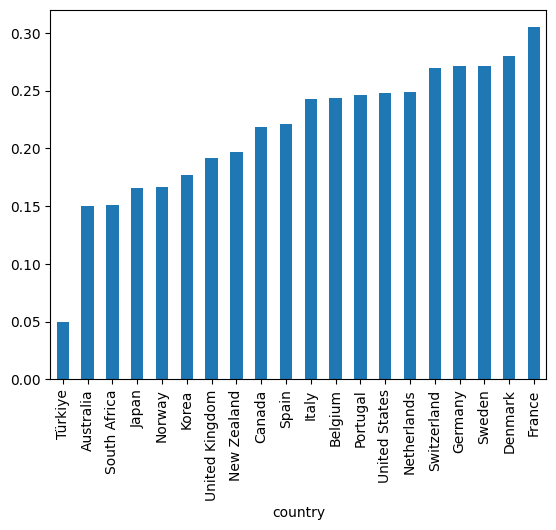

In [28]:
pd.Series(model.all_eigenvectors[:, 0], index = model.data_wide_columns).sort_values().plot.bar()

PC1 dominated by Peru and Argentina

# 3. Evaluation

In [29]:
df["country"].unique()

array(['Japan', 'Canada', 'United States', 'Australia', 'New Zealand',
       'Switzerland', 'Italy', 'France', 'Portugal', 'Spain', 'Sweden',
       'Denmark', 'United Kingdom', 'Germany', 'Netherlands', 'Norway',
       'Belgium', 'Korea', 'South Africa', 'Türkiye'], dtype=object)

In [30]:
preds = model.predict(df)
preds

,date,country,inflation
420,2020-01-01,Australia,0.009569
421,2020-01-01,Belgium,0.004269
422,2020-01-01,Canada,0.007015
423,2020-01-01,Denmark,0.003123
424,2020-01-01,France,0.002139
425,2020-01-01,Germany,0.003412
426,2020-01-01,Italy,0.003773
427,2020-01-01,Japan,0.002510
428,2020-01-01,Korea,0.005552
429,2020-01-01,Netherlands,0.003581


# 4. H-period ahead forecasting

In [31]:
df

,country,date,inflation,gdp_growth,interest_rate,unemployment_rate,commodity_CRUDE_PETRO,commodity_iNATGAS,commodity_iAGRICULTURE,commodity_iMETMIN,commodity_iPRECIOUSMET
0,Japan,1977-01-01,0.022951,2.187257,6.333333,2.3,0.00000,0.052425,0.144757,0.041940,0.112740
1,Canada,1977-01-01,0.023904,1.533830,8.166667,8.8,0.00000,0.052425,0.144757,0.041940,0.112740
2,United States,1977-01-01,0.017231,1.186233,4.700000,8.2,0.00000,0.052425,0.144757,0.041940,0.112740
3,Japan,1977-04-01,0.027244,0.703788,5.000000,2.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
4,Canada,1977-04-01,0.023346,0.510302,7.666667,8.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
...,...,...,...,...,...,...,...,...,...,...,...
2166,Italy,2023-01-01,0.003938,0.552944,3.000000,8.3,-0.02041,-0.585458,0.002037,0.007418,0.043183
2167,Canada,2023-01-01,0.006080,0.610026,4.500000,5.4,-0.02041,-0.585458,0.002037,0.007418,0.043183
2168,Sweden,2023-01-01,0.014955,0.656897,2.833333,7.8,-0.02041,-0.585458,0.002037,0.007418,0.043183
2169,Korea,2023-01-01,0.010538,0.329875,3.500000,3.2,-0.02041,-0.585458,0.002037,0.007418,0.043183


In [32]:
from seminartools.models.utils import h_period_ahead_forecast

forecast = h_period_ahead_forecast(model, df, "2010-01-01", h=1)
forecast

,date,country,inflation
0,2011-01-01,Australia,0.013892
1,2011-01-01,Belgium,0.008899
2,2011-01-01,Canada,0.012360
3,2011-01-01,Denmark,0.007605
4,2011-01-01,France,0.006042
...,...,...,...
975,2020-01-01,Sweden,0.002098
976,2020-01-01,Switzerland,-0.000114
977,2020-01-01,Türkiye,0.021333
978,2020-01-01,United Kingdom,0.003578


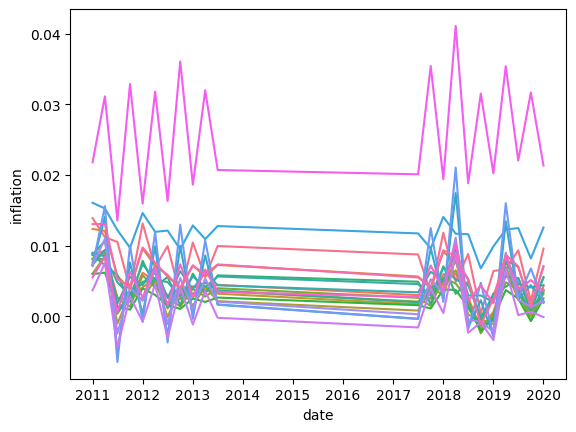

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data = forecast,
    x = "date",
    y = "inflation",
    hue = "country"
)
# turn off legend
plt.legend().remove()

# 5. Compare the forecast with the actual data

In [34]:
forecast_merged = forecast.copy().rename(columns={"inflation": "pred"})
forecast_merged = forecast_merged.merge(
    df[["country", "date", "inflation"]],
    on=["country", "date"],
    how="left",
).rename(columns={"inflation": "actual"})
forecast_merged.tail(100)

,date,country,pred,actual
880,2020-01-01,Australia,0.009569,0.003707
881,2020-01-01,Belgium,0.004269,0.007414
882,2020-01-01,Canada,0.007015,0.003711
883,2020-01-01,Denmark,0.003123,0.001940
884,2020-01-01,France,0.002139,-0.000955
...,...,...,...,...
975,2020-01-01,Sweden,0.002098,-0.009302
976,2020-01-01,Switzerland,-0.000114,-0.000989
977,2020-01-01,Türkiye,0.021333,0.024145
978,2020-01-01,United Kingdom,0.003578,0.000923


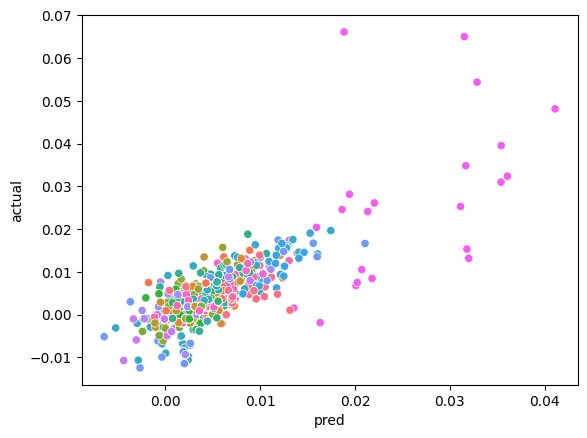

In [35]:
sns.scatterplot(
    data = forecast_merged,
    x = "pred",
    y = "actual",
    hue = "country"
)
plt.legend().remove()

In [36]:
import statsmodels.api as sm

sm.OLS(
    forecast_merged["actual"], sm.add_constant(forecast_merged["pred"])
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actual   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 27 Mar 2024   Prob (F-statistic):                nan
Time:                        15:47:29   Log-Likelihood:                    nan
No. Observations:                 980   AIC:                               nan
Df Residuals:                     978   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        nan         nan         nan
pred              nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         183.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
model.var.models["PC1"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PC1   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     3.664
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           9.15e-10
Time:                        15:47:29   Log-Likelihood:                -123.10
No. Observations:                 177   AIC:                             394.2
Df Residuals:                     103   BIC:                             629.2
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.3161      1.089      0.290      0.772      -1.843       2.476
PC1_lag_1                                 -0.0871      0.102     -0.858      0.393      -0.289       0.114
PC2_lag_1                                 -0.1757      0.198     -0.886      0.378      -0.569       0.218
PC1_lag_2                                 -0.4090      0.104     -3.942      0.000      -0.615      -0.203
PC2_lag_2                                  0.2949      0.250      1.178      0.242      -0.202       0.791
PC1_lag_3                                 -0.0933      0.102     -0.912      0.364      -0.296       0.110
PC2_lag_3                                  0.3858      0.280      1.380      0.171      -0.169       0.940
PC1_lag_4                                  0.2862      0.104      2.753      0.007       0.080       0.492
PC2_lag_4                                  0.3394      0.209      1.621      0.108      -0.076       0.755
gdp_growth_Australia_lag_1                 0.1681      0.086      1.960      0.053      -0.002       0.338
gdp_growth_Belgium_lag_1                   0.1606      0.252      0.637      0.525      -0.339       0.660
gdp_growth_Canada_lag_1                    0.0924      0.103      0.897      0.372      -0.112       0.297
gdp_growth_Denmark_lag_1                  -0.1014      0.128     -0.795      0.429      -0.355       0.152
gdp_growth_France_lag_1                   -0.0783      0.249     -0.314      0.754      -0.572       0.416
gdp_growth_Germany_lag_1                   0.2331      0.165      1.410      0.161      -0.095       0.561
gdp_growth_Italy_lag_1                     0.5105      0.271      1.886      0.062      -0.026       1.047
gdp_growth_Japan_lag_1                    -0.0265      0.072     -0.366      0.715      -0.170       0.117
gdp_growth_Korea_lag_1                    -0.0019      0.128     -0.015      0.988      -0.256       0.252
gdp_growth_Netherlands_lag_1               0.0997      0.225      0.443      0.659      -0.347       0.547
gdp_growth_New Zealand_lag_1              -0.1040      0.085     -1.226      0.223      -0.272       0.064
gdp_growth_Norway_lag_1                   -0.0345      0.102     -0.337      0.737      -0.237       0.168
gdp_growth_Portugal_lag_1                  0.0159      0.142      0.112      0.911      -0.266       0.298
gdp_growth_South Africa_lag_1              0.1636      0.153      1.067      0.289      -0.141       0.468
gdp_growth_Spain_lag_1                     0.4780      0.343      1.395      0.166      -0.201       1.157
gdp_growth_Sweden_lag_1                   -0.1932      0.143     -1.348      0.181      -0.477       0.091
gdp_growth_Switzerland_lag_1              -0.0293      0.285     -0.103      0.918     